# California housing example

California Housing is a dataset from the 1990 U.S. census. It contains median house prices (`MedHouseVal`) for several thousand districts throughout California. It also provides a number of variables, such as districts population, average number of rooms and bedrooms, as well as latitude and longitude. The aim is to predict `MedHouseVal` based on these variables. For more details, see: https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In this notebook, we try to identify the most important variables and pairs of variables, and study the influence of restricting ourselves to a subpart of the data (e.g., the most expensive or least expensive houses).

In [1]:
import os
import sys

import yaml
import itertools as itt

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

sys.path.append(os.path.join(os.path.abspath(""), ".."))

from infovar import DiscreteHandler, ContinuousHandler, StandardGetter
from infovar.stats.ranking import prob_higher

## Dataset

In [2]:
dataset = datasets.fetch_california_housing()

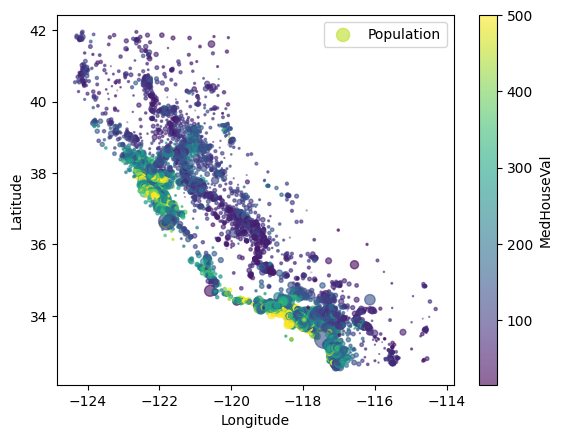

In [3]:
plt.figure()

housing = datasets.fetch_california_housing(as_frame=True).frame
housing["MedHouseVal"] *= 1e2

axs = housing.plot(
    kind="scatter", x="Longitude",y="Latitude", c="MedHouseVal", colorbar=True, legend=True, ax=plt.gca(), s=housing['Population']/200, label="Population", alpha=0.6
)

plt.show()

In [4]:
# Filter data > $500,000 that saturate
filt = dataset.target < 5

In [5]:
_variables = np.concatenate(
    [
        dataset.data[filt],
        np.random.normal(0, 1, size=(filt.sum(), 1)),
    ], axis=1
)
_targets = 1e2 * dataset.target[filt].reshape(-1, 1) # Conversion in $1,000

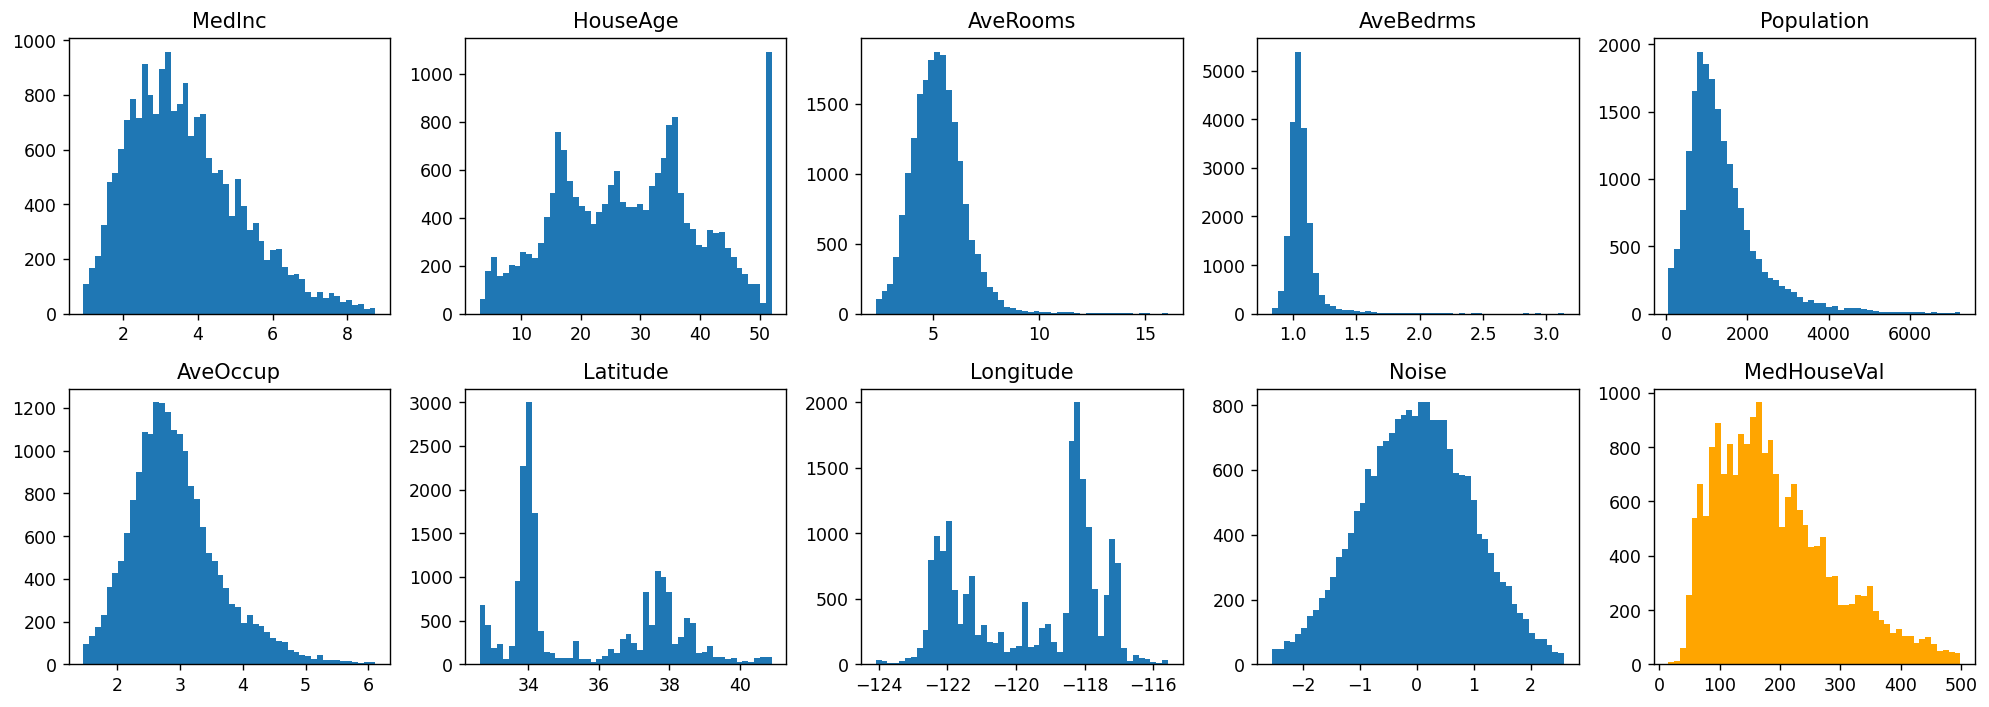

In [6]:
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(2.5*6.4, 1.2*4.8), dpi=125)
axs = axs.flatten()

for i, name in enumerate(dataset.feature_names + ["Noise"]):
    x = _variables[:, i]
    low, upp = np.percentile(x, 0.5), np.percentile(x, 99.5)
    axs[i].hist(x[(x >= low) & (x <= upp)], bins=50)
    axs[i].set_title(f"{name}")

axs[-1].hist(_targets[:, 0], bins=50, color="orange")
axs[-1].set_title(f"{dataset.target_names[0]}")

plt.tight_layout()
plt.show()

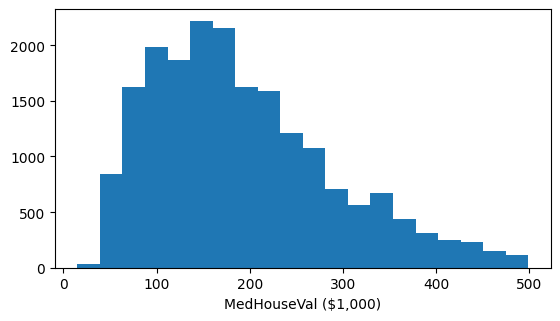

In [7]:
plt.figure(figsize=(6.4, 0.7*4.8))

plt.hist(_targets, bins=20)
plt.xlabel(f"{dataset.target_names[0]} ($1,000)")

plt.show()

### Handler

In [8]:
save_path = os.path.join(abspath, "california-housing", "data-out")

handler = DiscreteHandler()

handler.set_path(
    save_path=save_path
)

In [9]:
feature_names = dataset.feature_names + ["Noise"]
target_names = dataset.target_names

getter = StandardGetter(
    feature_names,
    target_names,
    _variables,
    _targets
)

handler.set_getter(
    getter.get
)

In [10]:
with open(os.path.join(abspath, "california-housing", 'ranges.yaml'), "r") as f:
    ranges = yaml.safe_load(f)

handler.set_restrictions(
    ranges    
)

### Data analysis

In [11]:
handler.overview()

DiscreteHandler
Save path: /home/einig/PHD/projects/infovar/examples/california-housing/data-out
Existing saves:


## Informativity of each variable

__Note:__ This part will take less than 1 min.

### Statistics computation

In [12]:
with open(os.path.join(abspath, "california-housing", 'inputs.yaml'), 'r') as f:
    inputs_dict = yaml.safe_load(f)

In [13]:
handler.update(
    feature_names,
    "MedHouseVal",
    inputs_dict,
    iterable_x=True
)

[MedHouseVal]: 100%|██████████| 9/9 [00:22<00:00,  2.54s/it, x=[Noise]]     


### Results analysis

In [14]:
targs = ["MedHouseVal"]

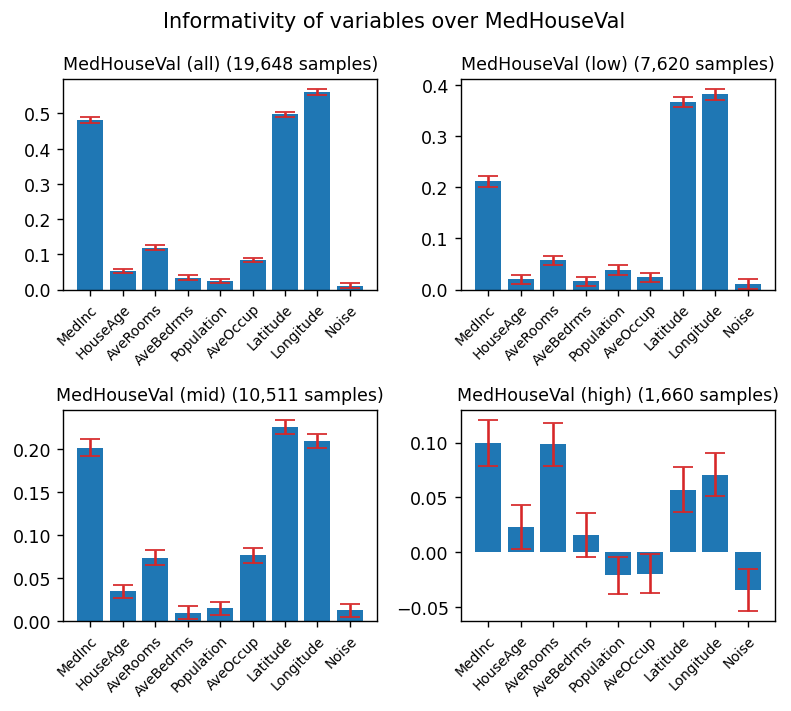

In [15]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    entries = handler.read(
        feature_names,
        targs,
        rg,
        iterable_x=True
    )

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=feature_names, rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({rg}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

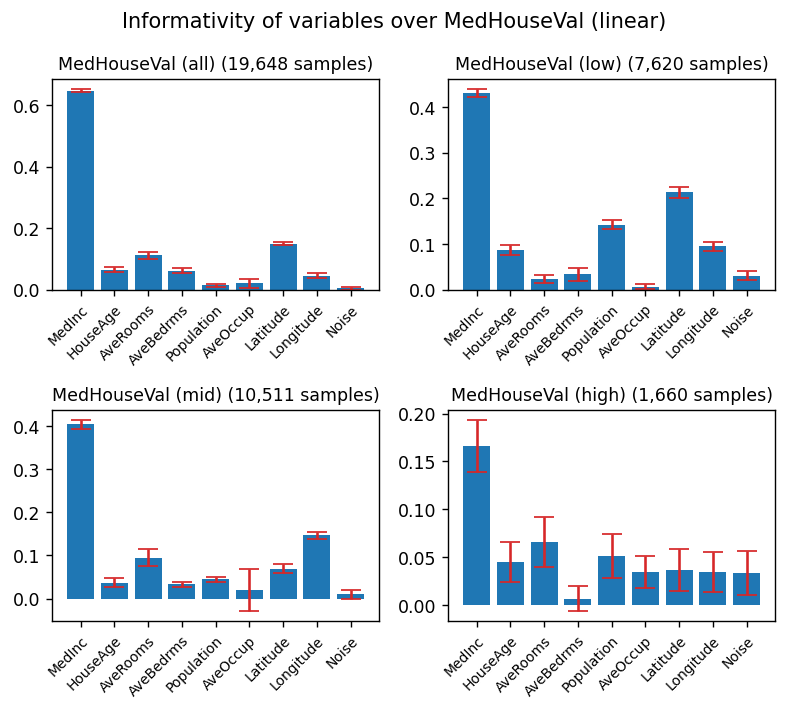

In [16]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("Informativity of variables over MedHouseVal (linear)")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    entries = handler.read(
        feature_names,
        targs,
        rg,
        iterable_x=True
    )

    corrs = [el["corr"]["value"] for el in entries]
    stds = [el["corr"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, corrs)
    plt.errorbar(xticks, corrs, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=feature_names, rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({rg}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Identification of most informative variable(s)

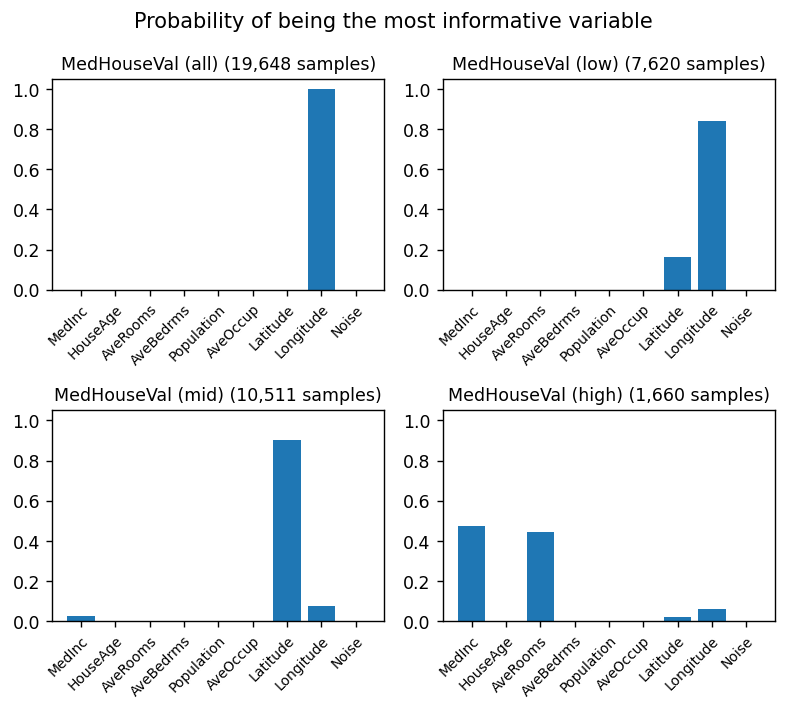

In [17]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("Probability of being the most informative variable")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    entries = handler.read(
        feature_names,
        targs,
        rg,
        iterable_x=True
    )

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    probs = prob_higher(mis, stds, approx=False)

    #

    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, probs)
    plt.xticks(xticks, labels=feature_names, rotation=45, fontsize=8, ha='right', rotation_mode='anchor')
    plt.ylim([0, 1.05])

    plt.title(f"MedHouseVal ({rg}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation: latitude and longitude

In [18]:
with open(os.path.join(abspath, "california-housing", "ranges.yaml"), "r") as f:
    ranges_dict = yaml.safe_load(f)

print("Considered range of values:")
for key, val in ranges_dict.items():
    print(key, val)

Considered range of values:
all {'MedHouseVal': [None, None]}
low {'MedHouseVal': [0, 150]}
mid {'MedHouseVal': [150, 350]}
high {'MedHouseVal': [350, 500]}


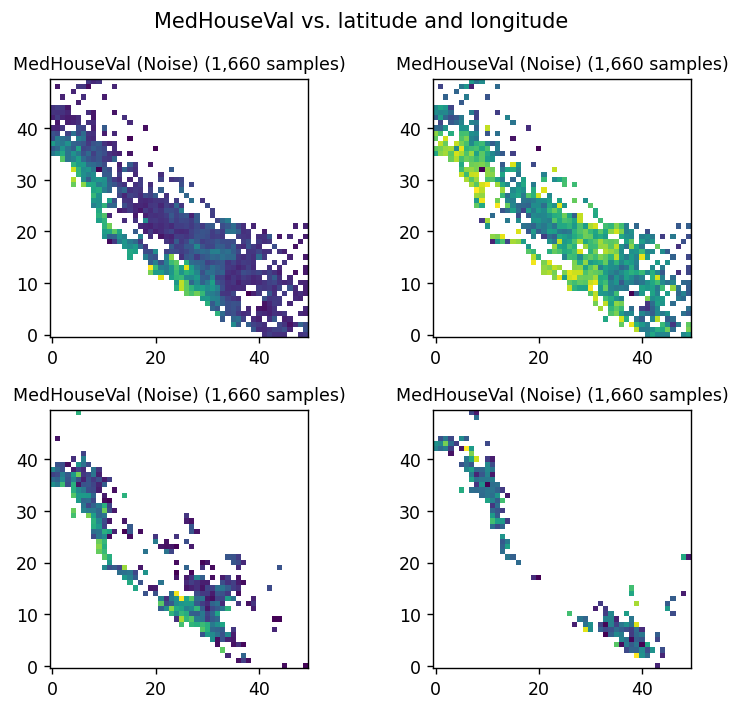

In [19]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("MedHouseVal vs. latitude and longitude")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    X, Y = getter.get(
        ["Latitude", "Longitude"],
        ["MedHouseVal"],
        ranges_dict[rg]
    )

    #

    ret = binned_statistic_2d(X[:, 0], X[:, 1], Y[:, 0], statistic=np.mean, bins=(50, 50))

    plt.subplot(2, 2, i)

    plt.imshow(ret.statistic.T, origin="lower")

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()


When you consider all the data, geographical position is essential. The figure above shows that most expensive homes are located in very specific areas.

When only expensive homes are considered, however, geographical location is no longer a determining factor. There doesn't seem to be any variable that is much more informative than the others.

## Informativity of a couple of two variables

__Note:__ This part will take a few minutes.

### Statistics computation

In [20]:
handler.update(
    list(itt.combinations(feature_names, 2)),
    "MedHouseVal",
    inputs_dict,
    iterable_x=True
)

[MedHouseVal]: 100%|██████████| 36/36 [01:43<00:00,  2.87s/it, x=[Longitude, Noise]]     


In [21]:
targs = ["MedHouseVal"]
comb_list = list(itt.combinations(feature_names, 2))

### Mutual information

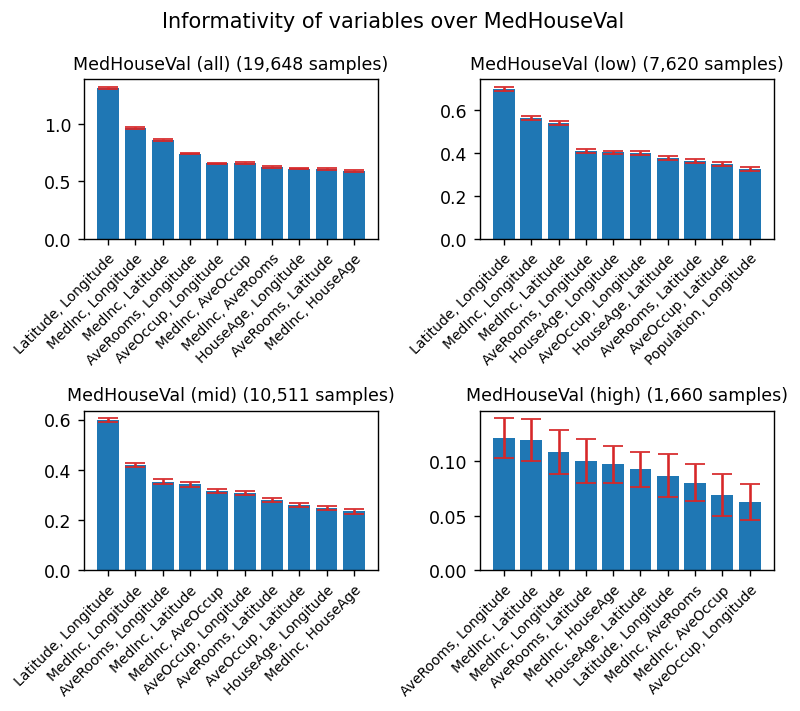

In [22]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    entries = handler.read(
        comb_list,
        targs,
        rg,
        iterable_x=True
    )

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    # We keep the 10 most informative combinations of variables
    order = np.argsort(mis)[::-1][:10]
    _mis = [mis[i] for i in order]
    _stds = [stds[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    #

    xticks = list(range(len(_mis)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, _mis)
    plt.errorbar(xticks, _mis, yerr=_stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=[", ".join(c) for c in _comb_list], rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({rg}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    entries = handler.read(
        comb_list,
        targs,
        rg,
        iterable_x=True
    )

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    probs = prob_higher(mis, stds)
    nz = np.count_nonzero(probs)

    order = np.argsort(probs)[::-1][:nz]
    _probs = [probs[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    print(f"Range: {rg}")
    for i, (p, c) in enumerate(zip(_probs, _comb_list), 1):
        print(f"{i}. {', '.join(c)}: {100*p:.1f}%")
    print()

Range: all
1. Latitude, Longitude: 100.0%

Range: low
1. Latitude, Longitude: 100.0%

Range: mid
1. Latitude, Longitude: 100.0%

Range: high
1. AveRooms, Longitude: 35.5%
2. MedInc, Latitude: 32.4%
3. MedInc, Longitude: 15.9%
4. AveRooms, Latitude: 7.6%
5. MedInc, HouseAge: 4.0%
6. Latitude, Longitude: 2.0%
7. HouseAge, Latitude: 1.9%
8. MedInc, AveRooms: 0.5%
9. MedInc, AveOccup: 0.2%



### Pearson correlation coefficient

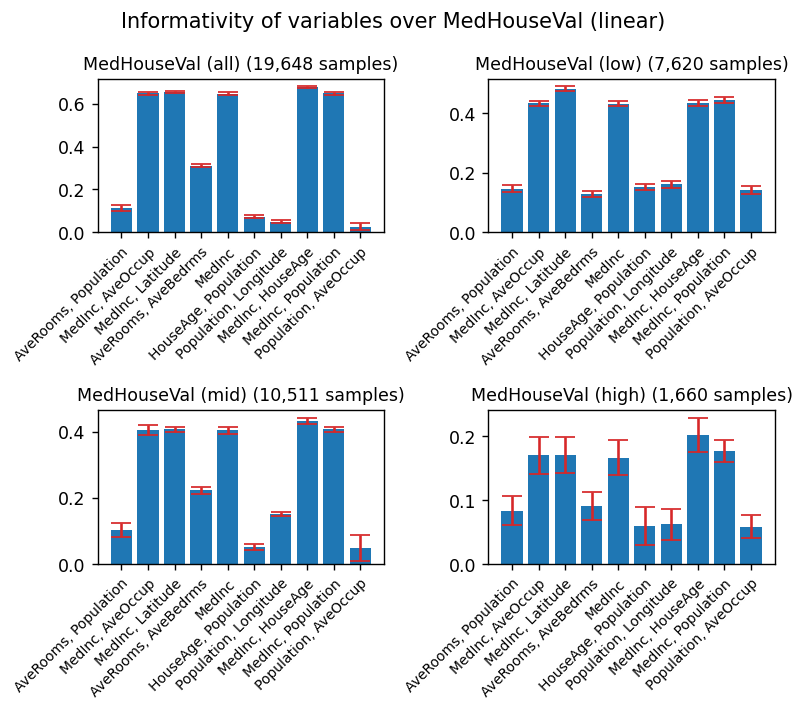

In [24]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=125)

plt.suptitle("Informativity of variables over MedHouseVal (linear)")

for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    comb_list = list(itt.combinations_with_replacement(feature_names, 2))
    for k, (v1, v2) in enumerate(comb_list):
        comb_list[k] = [v1] if v1 == v2 else [v1, v2]

    entries = handler.read(
        comb_list,
        targs,
        rg,
        iterable_x=True
    )

    corrs = [el["corr"]["value"] for el in entries]
    stds = [el["corr"]["std"] for el in entries]
    samples = entries[0]["samples"]

    # We keep the 10 most informative combinations of variables
    order = np.argsort(mis)[::-1][:10]
    _corrs = [corrs[i] for i in order]
    _stds = [stds[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    #

    xticks = list(range(len(_mis)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, _corrs)
    plt.errorbar(xticks, _corrs, yerr=_stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=[", ".join(c) for c in _comb_list], rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({rg}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
for i, rg in enumerate(["all", "low", "mid", "high"], 1):

    handler.read(
        comb_list,
        targs,
        rg,
        iterable_x=True
    )

    corrs = [el["corr"]["value"] for el in entries]
    stds = [el["corr"]["std"] for el in entries]
    samples = entries[0]["samples"]

    probs = prob_higher(corrs, stds)
    nz = np.count_nonzero(probs)

    order = np.argsort(probs)[::-1][:nz]
    _probs = [probs[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    print(f"Range: {rg}")
    for i, (p, c) in enumerate(zip(_probs, _comb_list), 1):
        print(f"{i}. {', '.join(c)}: {100*p:.1f}%")
    print()

Range: all
1. MedInc, HouseAge: 45.2%
2. MedInc, Latitude: 9.3%
3. MedInc, AveOccup: 9.3%
4. MedInc, Longitude: 9.2%
5. MedInc, AveRooms: 7.7%
6. MedInc: 6.2%
7. MedInc, Population: 5.5%
8. MedInc, Noise: 5.3%
9. MedInc, AveBedrms: 2.2%

Range: low
1. MedInc, HouseAge: 45.2%
2. MedInc, Latitude: 9.3%
3. MedInc, AveOccup: 9.3%
4. MedInc, Longitude: 9.2%
5. MedInc, AveRooms: 7.7%
6. MedInc: 6.2%
7. MedInc, Population: 5.5%
8. MedInc, Noise: 5.3%
9. MedInc, AveBedrms: 2.2%

Range: mid
1. MedInc, HouseAge: 45.2%
2. MedInc, Latitude: 9.3%
3. MedInc, AveOccup: 9.3%
4. MedInc, Longitude: 9.2%
5. MedInc, AveRooms: 7.7%
6. MedInc: 6.2%
7. MedInc, Population: 5.5%
8. MedInc, Noise: 5.3%
9. MedInc, AveBedrms: 2.2%

Range: high
1. MedInc, HouseAge: 45.2%
2. MedInc, Latitude: 9.3%
3. MedInc, AveOccup: 9.3%
4. MedInc, Longitude: 9.2%
5. MedInc, AveRooms: 7.7%
6. MedInc: 6.2%
7. MedInc, Population: 5.5%
8. MedInc, Noise: 5.3%
9. MedInc, AveBedrms: 2.2%



## Continuous analysis

In [26]:
save_path = os.path.join(abspath, "california-housing", "data-out-continuous")

handler = ContinuousHandler()

handler.set_path(
    save_path=save_path
)

handler.set_getter(
    getter.get
)

### Statistics computation

__Note:__ This part will a few minutes

In [27]:
with open(os.path.join(abspath, "california-housing", 'inputs_cont.yaml'), 'r') as f:
    inputs_dict_cont = yaml.safe_load(f)

In [28]:
for feature in feature_names + [["Latitude", "Longitude"]]:
    handler.update(
        feature,
        "MedHouseVal",
        inputs_dict_cont
    )

### Results

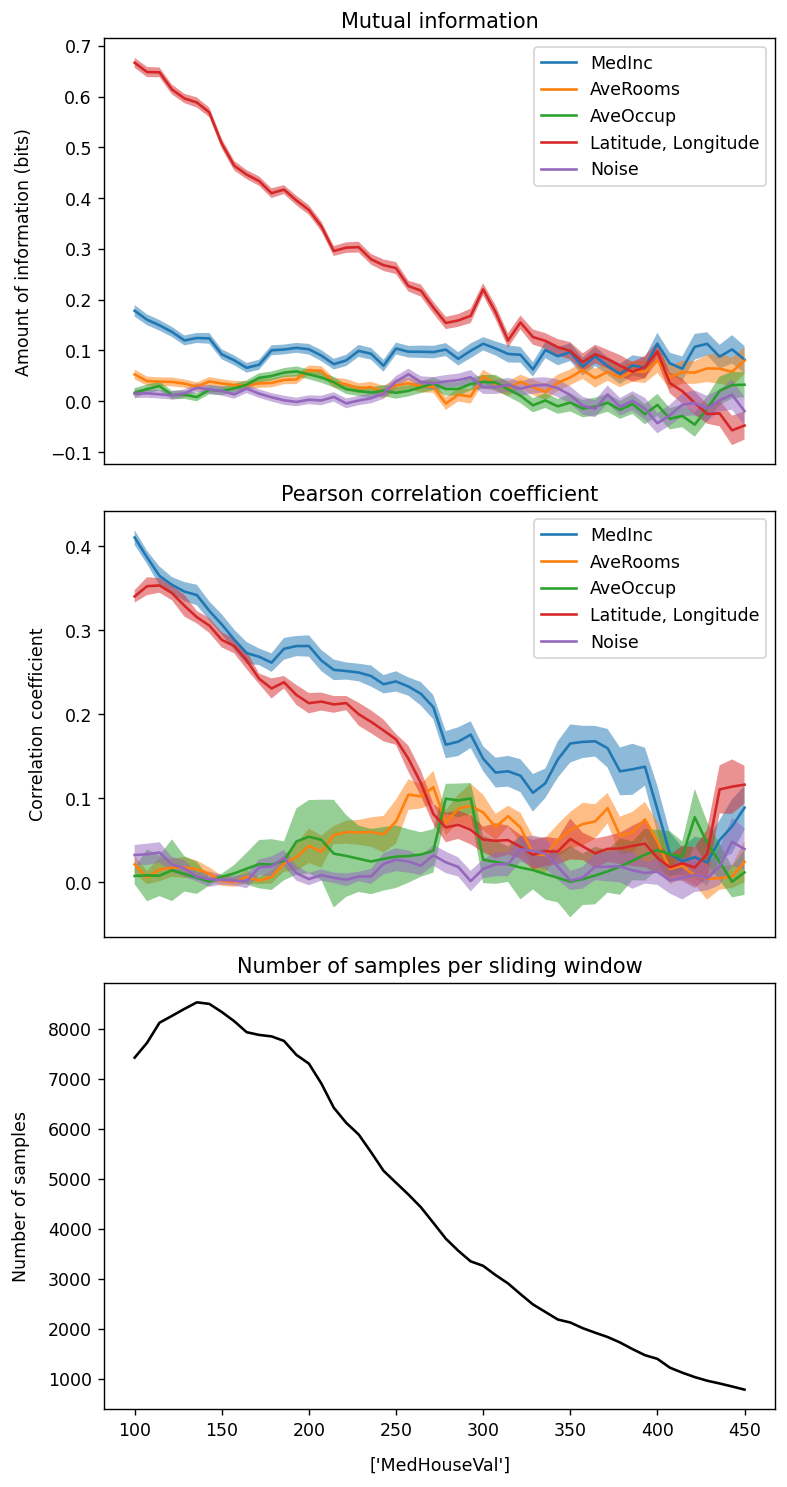

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6.4, 2.5*4.8), dpi=125)

# vmax = 0
for i, var in enumerate(
    ["MedInc", "AveRooms", "AveOccup", ["Latitude", "Longitude"], "Noise"]
):

    d = handler.read(
        var,
        target_names,
        target_names # Sliding window
    )["stats"]

    xticks = d["mi"]["coords"][0]
    prof_mi = d["mi"]["data"]
    prof_corr = d["corr"]["data"]
    prof_mi_std = d["mi"]["std"]
    prof_corr_std = d["corr"]["std"]
    prof_samples = d["mi"]["samples"]

    label = var if isinstance(var, str) else f"{', '.join(var)}"

    ax1.plot(xticks, prof_mi, label=label)
    ax2.plot(xticks, prof_corr, label=label)
    if i == 0:
        ax3.plot(xticks, prof_samples, label=label, color="black")

    ax1.fill_between(xticks, prof_mi-prof_mi_std, prof_mi+prof_mi_std, alpha=0.5)
    ax2.fill_between(xticks, prof_corr-prof_corr_std, prof_corr+prof_corr_std, alpha=0.5)

ax1.set_xticks([])
ax2.set_xticks([])

ax3.set_xlabel(target_names, labelpad=10)
ax1.set_ylabel("Amount of information (bits)", labelpad=10)
ax2.set_ylabel("Correlation coefficient", labelpad=10)
ax3.set_ylabel("Number of samples", labelpad=10)

ax1.set_title("Mutual information")
ax2.set_title("Pearson correlation coefficient")
ax3.set_title("Number of samples per sliding window")

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()